# Initialize

In [2]:
import os
from typing import Dict, Any, Tuple
import numpy as np
# import scipy

import pandas as pd
import polars as pl

import skfuzzy as fuzz
from scipy.spatial.distance import cdist

import matplotlib.pyplot as plt
import seaborn as sns


path_proj_root = '/Users/curtismcginity/stanford/research/proj/MoTrPAC/dev/'
path_data = os.path.join(path_proj_root, 'data')
path_data_r6m = os.path.join(path_data, 'rat-6m')
path_contrast_time_txt = os.path.join(path_data_r6m, 'rat-acute-06_t68-liver_epigen-atac-seq_da_timewise-deseq2-phase-frip-t2f_v2.0.txt')
path_indv_tsv = p=os.path.join(path_data_r6m, 'motrpac_pass1ac-06_epigen-atac-seq_t68-liver_stanford_limma_norm.tsv')

# paths to read in the pre-stored parquet files
ptxt = os.path.join(path_data_r6m, 'rat-acute-06_t68-liver_epigen-atac-seq_da_timewise-deseq2-phase-frip-t2f_v2.0.parquet')
pindv = os.path.join(path_data_r6m, 'motrpac_pass1ac-06_epigen-atac-seq_t68-liver_stanford_limma_norm.parquet')

# read in parquet files, filter for sex=male, then pass to pandas
dfplmale = pl.read_parquet(ptxt).filter(pl.col("sex") == "male")
dfmale = dfplmale.to_pandas()

def standardize_data_types(df):
    """
    Standardize data types of the dataframe according to specified requirements.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The dataframe to standardize
        
    Returns:
    --------
    pandas.DataFrame
        The dataframe with standardized data types
    """
    # Convert text columns to string type
    text_columns = ['assay', 'feature_ID', 'tissue', 'contrast', 'timepoint', 'sex']
    for col in text_columns:
        if col in df.columns:
            df[col] = df[col].astype(str)
    
    # Convert float columns
    float_columns = ['logFC', 'lfcSE', 'p_value']
    for col in float_columns:
        if col in df.columns:
            df[col] = df[col].astype(float)
    
    # Handle adj_p_value column - convert 'NA' to 1.0
    if 'adj_p_value' in df.columns:
        # Replace 'NA' with 1.0
        df['adj_p_value'] = df['adj_p_value'].replace('NA', 1.0)
        # Convert to float
        df['adj_p_value'] = df['adj_p_value'].astype(float)
    
    return df


def classification_entropy(membership_matrix: np.ndarray) -> float:
    """Calculate entropy of fuzzy membership matrix: -1/n * sum_i sum_j (u_ij * log(u_ij))"""
    epsilon = np.finfo(float).eps
    u = np.clip(membership_matrix, epsilon, 1.0)
    n = membership_matrix.shape[1]
    return -1.0 / n * np.sum(u * np.log(u))


def xie_beni_index(data: np.ndarray, centers: np.ndarray, 
                  membership_matrix: np.ndarray, m: float) -> float:
    """Calculate Xie-Beni index: ratio of within-cluster compactness to between-cluster separation"""
    n = data.shape[0]  # Number of data points
    c = centers.shape[0]  # Number of clusters
    
    # Calculate compactness (numerator)
    u_power_m = membership_matrix ** m
    
    # Calculate squared distances between data points and centers
    squared_distances = np.zeros_like(membership_matrix)
    for j in range(c):
        squared_distances[j, :] = np.sum((data - centers[j, :]) ** 2, axis=1)
    
    compactness = np.sum(u_power_m * squared_distances)
    
    # Calculate separation (minimum distance between centers)
    if c > 1:
        # Explicitly calculate pairwise distances without using the inf trick
        min_dist_sq = float('inf')
        for i in range(c):
            for j in range(c):
                if i != j:  # Don't compare a center to itself
                    dist_sq = np.sum((centers[i] - centers[j]) ** 2)
                    min_dist_sq = min(min_dist_sq, dist_sq)
        
        # Guard against potential division by zero
        if min_dist_sq > 0:
            return compactness / (n * min_dist_sq)
        else:
            return float('inf')  # Centers are identical
    else:
        return float('inf')  # Only one cluster


def preprocess_data_for_clustering(df: pd.DataFrame) -> Tuple[np.ndarray, list, list]:
    """Transform dataframe into format for clustering: each feature_ID becomes a row with 7 timepoint values"""
    # Get unique timepoints and sort them
    timepoints = sorted(df['timepoint'].unique())
    
    # Create a pivot table: rows=feature_ID, columns=timepoint, values=logFC
    pivot_df = df.pivot_table(
        index='feature_ID', 
        columns='timepoint', 
        values='logFC',
        aggfunc='first'
    )
    
    pivot_df = pivot_df[timepoints]
    feature_ids = pivot_df.index.tolist()
    data = pivot_df.values
    
    return data, feature_ids, timepoints


def cmeans_clustering(
    df: pd.DataFrame,
    n_clusters: int = 2,
    fuzziness: float = 2.0,
    error: float = 0.001,
    max_iter: int = 100,
    random_seed: int = None
) -> Dict[str, Any]:
    """
    Cluster feature_IDs based on their logFC patterns across timepoints.
    Each feature_ID becomes one sample with 7 dimensions (timepoints).
    
    Parameters:
    -----------
    df : pd.DataFrame
        Dataframe containing feature_ID, timepoint, and logFC columns
    n_clusters : int, default=2
        Number of clusters to form
    fuzziness : float, default=2.0
        Fuzziness parameter m where m > 1
    error : float, default=0.001
        Stopping criterion for convergence
    max_iter : int, default=100
        Maximum number of iterations
    random_seed : int, default=None
        Random seed for initialization. If None, a random value will be generated.
        
    Returns:
    --------
    Dict containing clustering results and parameters
    """
    # Preprocess data: each row is a feature_ID, each column a timepoint
    data, feature_ids, timepoints = preprocess_data_for_clustering(df)
    # Transpose data for skfuzzy (expects shape: features, samples)
    data_t = data.T
    
    # Handle random seed
    if random_seed is None:
        random_seed = np.random.randint(0, 10000)
    print(f"Using random seed: {random_seed}")
    # Set the random seed for numpy
    np.random.seed(random_seed)
    
    # Perform fuzzy c-means clustering
    cntr, u, _, d, jm, p, fpc = fuzz.cluster.cmeans(
        data=data_t,
        c=n_clusters,
        m=fuzziness,
        error=error,
        maxiter=max_iter,
        init=None
    )
    
    # Determine hard cluster assignments based on maximum membership
    cluster_assignments = np.argmax(u, axis=0)
    
    # Calculate metrics
    ce = classification_entropy(u)
    xbi = xie_beni_index(data, cntr, u, fuzziness)
    
    return {
        'centers': cntr,
        'membership': u,
        'cluster_assignments': cluster_assignments,
        'classification_entropy': ce,
        'xie_beni_index': xbi,
        'feature_ids': feature_ids,
        'timepoints': timepoints,
        'fpc': fpc,
        'random_seed': random_seed
    }

def plot_cluster_centroids(
    clustering_result: Dict[str, Any],
    df: pd.DataFrame,
    show_features: bool = True,
    feature_alpha: float = 0.15,
    palette: str = "viridis"
):
    """
    Plot cluster centroids as line plots with optional feature patterns.
    
    Parameters:
    -----------
    clustering_result : Dict
        Output from cmeans_clustering function
    df : pd.DataFrame
        Original dataframe with feature_ID, timepoint, and logFC
    show_features : bool, default=True
        Whether to show individual feature patterns within clusters
    feature_alpha : float, default=0.2
        Transparency for feature lines
    palette : str, default="viridis"
        Color palette to use for clusters
    """
    # Set seaborn style for professional scientific plots
    sns.set_style("whitegrid")
    sns.set_context("paper", font_scale=1.2)
    
    # Extract key components from clustering result
    centers = clustering_result['centers']
    timepoints = clustering_result['timepoints']
    feature_ids = clustering_result['feature_ids']
    cluster_assignments = clustering_result['cluster_assignments']
    n_clusters = centers.shape[0]
    
    # Create color palette for clusters
    colors = sns.color_palette(palette, n_clusters)
    
    # Get assay and tissue name for title
    assay_name = df['assay'].iloc[0] if 'assay' in df.columns else ''
    tissue_name = df['tissue'].iloc[0] if 'tissue' in df.columns else ''
    
    # Create figure
    plt.figure(figsize=(10, 6))
    
    # Calculate y-axis range
    all_logfc = df['logFC'].values
    y_min, y_max = all_logfc.min(), all_logfc.max()
    y_range = y_max - y_min
    y_limits = [y_min - 0.1 * y_range, y_max + 0.1 * y_range]
    
    # First plot individual feature patterns if requested
    if show_features:
        feature_to_cluster = {fid: c for fid, c in zip(feature_ids, cluster_assignments)}
        
        for feature_id, group in df.groupby('feature_ID'):
            if feature_id in feature_to_cluster:
                cluster = feature_to_cluster[feature_id]
                group_sorted = group.sort_values('timepoint')
                plt.plot(
                    group_sorted['timepoint'], 
                    group_sorted['logFC'], 
                    color=colors[cluster], 
                    alpha=feature_alpha,
                    linewidth=0.8
                )
    
    # Plot cluster centroids (thick lines)
    for i in range(n_clusters):
        plt.plot(
            timepoints, 
            centers[i], 
            color=colors[i], 
            linewidth=3, 
            label=f'Cluster {i+1}'
        )
    
    # Set x-ticks to timepoints with rotation
    plt.xticks(range(len(timepoints)), timepoints, rotation=45)
    
    # Set y-axis limits
    plt.ylim(y_limits)
    
    # Add labels and legend
    plt.xlabel('Timepoint')
    plt.ylabel('Log Fold Change')
    plt.title(f'{assay_name} {tissue_name} Male Cluster Centroids (n={n_clusters})')
    plt.legend()
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

def plot_only_centroids(
    clustering_result: Dict[str, Any],
    df: pd.DataFrame,
    palette: str = "viridis"
):
    """
    Plot only the cluster centroids as line plots.
    
    Parameters:
    -----------
    clustering_result : Dict
        Output from cmeans_clustering function
    df : pd.DataFrame
        Original dataframe with feature_ID, timepoint, and logFC
    palette : str, default="viridis"
        Color palette to use for clusters
    """
    # Set seaborn style for professional scientific plots
    sns.set_style("whitegrid")
    sns.set_context("paper", font_scale=1.2)
    
    # Extract key components from clustering result
    centers = clustering_result['centers']
    timepoints = clustering_result['timepoints']
    n_clusters = centers.shape[0]
    
    # Create color palette for clusters
    colors = sns.color_palette(palette, n_clusters)
    
    # Get assay and tissue name for title
    assay_name = df['assay'].iloc[0] if 'assay' in df.columns else ''
    tissue_name = df['tissue'].iloc[0] if 'tissue' in df.columns else ''
    
    # Create figure
    plt.figure(figsize=(10, 6))
    
    # Calculate y-axis range for centers only
    center_min = centers.min()
    center_max = centers.max()
    y_range = center_max - center_min
    y_limits = [center_min - 0.1 * y_range, center_max + 0.1 * y_range]
    
    # Plot cluster centroids (thick lines)
    for i in range(n_clusters):
        plt.plot(
            timepoints, 
            centers[i], 
            color=colors[i], 
            linewidth=3, 
            label=f'Cluster {i+1}'
        )
    
    # Set x-ticks to timepoints with rotation
    plt.xticks(range(len(timepoints)), timepoints, rotation=45)
    
    # Set y-axis limits
    plt.ylim(y_limits)
    
    # Add labels and legend
    plt.xlabel('Timepoint')
    plt.ylabel('Log Fold Change')
    plt.title(f'{assay_name} {tissue_name} Male Cluster Centroids (n={n_clusters})')
    plt.legend()
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

def plot_individual_clusters(
    clustering_result: Dict[str, Any],
    df: pd.DataFrame,
    feature_alpha: float = 0.15,
    palette: str = "viridis"
):
    """
    Create individual plots for each cluster.
    
    Parameters:
    -----------
    clustering_result : Dict
        Output from cmeans_clustering function
    df : pd.DataFrame
        Original dataframe with feature_ID, timepoint, and logFC
    feature_alpha : float, default=0.3
        Transparency for feature lines
    palette : str, default="viridis"
        Color palette to use for clusters
    """
    # Set seaborn style for professional scientific plots
    sns.set_style("whitegrid")
    sns.set_context("paper", font_scale=1.2)
    
    # Extract key components from clustering result
    centers = clustering_result['centers']
    timepoints = clustering_result['timepoints']
    feature_ids = clustering_result['feature_ids']
    cluster_assignments = clustering_result['cluster_assignments']
    n_clusters = centers.shape[0]
    
    # Create color palette for clusters
    colors = sns.color_palette(palette, n_clusters)
    
    # Get assay and tissue name for title
    assay_name = df['assay'].iloc[0] if 'assay' in df.columns else ''
    tissue_name = df['tissue'].iloc[0] if 'tissue' in df.columns else ''
    
    # Calculate y-axis range for consistency across plots
    all_logfc = df['logFC'].values
    y_min, y_max = all_logfc.min(), all_logfc.max()
    y_range = y_max - y_min
    y_limits = [y_min - 0.1 * y_range, y_max + 0.1 * y_range]
    
    # Create mapping from feature_id to cluster
    feature_to_cluster = {fid: c for fid, c in zip(feature_ids, cluster_assignments)}
    
    # Create one plot for each cluster
    for cluster_idx in range(n_clusters):
        plt.figure(figsize=(10, 6))
        
        # First plot the individual features in this cluster
        for feature_id, group in df.groupby('feature_ID'):
            if feature_id in feature_to_cluster and feature_to_cluster[feature_id] == cluster_idx:
                group_sorted = group.sort_values('timepoint')
                plt.plot(
                    group_sorted['timepoint'], 
                    group_sorted['logFC'], 
                    color=colors[cluster_idx], 
                    alpha=feature_alpha,
                    linewidth=0.8
                )
        
        # Then plot the centroid
        plt.plot(
            timepoints, 
            centers[cluster_idx], 
            color=colors[cluster_idx], 
            linewidth=3, 
            label=f'Cluster {cluster_idx+1} Centroid'
        )
        
        # Count features in this cluster
        n_features = sum(1 for c in cluster_assignments if c == cluster_idx)
        
        # Set x-ticks to timepoints with rotation
        plt.xticks(range(len(timepoints)), timepoints, rotation=45)
        
        # Set y-axis limits
        plt.ylim(y_limits)
        
        # Add labels and legend
        plt.xlabel('Timepoint')
        plt.ylabel('Log Fold Change')
        plt.title(f'{assay_name} {tissue_name} Male - Cluster {cluster_idx+1} ({n_features} features)')
        plt.legend()
        
        # Adjust layout
        plt.tight_layout()
        plt.show()


def find_optimal_clusters(
    df: pd.DataFrame,
    cluster_range: range = range(3, 7),
    fuzziness: float = 2.0,
    random_seed: int = 9620
) -> Dict[str, Any]:
    """Find optimal number of clusters by evaluating metrics across cluster counts"""
    metrics = []
    all_results = {}
    
    for n in cluster_range:
        print(f"Clustering with {n} clusters...")
        result = cmeans_clustering(df, n_clusters=n, fuzziness=fuzziness, random_seed=random_seed)
        
        metrics.append({
            'n_clusters': n,
            'classification_entropy': result['classification_entropy'],
            'xie_beni_index': result['xie_beni_index'],
            'fpc': result['fpc']
        })
        
        all_results[n] = result
    
    metrics_df = pd.DataFrame(metrics)
    
    # Create metric plots for determining optimal clusters
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    ax1.plot(metrics_df['n_clusters'], metrics_df['xie_beni_index'], 'o-')
    ax1.set_xlabel('Number of Clusters')
    ax1.set_ylabel('Xie-Beni Index')
    ax1.set_title(f'Xie-Beni Index vs. Number of Clusters (fuzziness={fuzziness})')
    ax1.set_yscale('log')
    
    ax2.plot(metrics_df['n_clusters'], metrics_df['fpc'], 'o-')
    ax2.set_xlabel('Number of Clusters')
    ax2.set_ylabel('Fuzzy Partition Coefficient')
    ax2.set_title('FPC vs. Number of Clusters')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'metrics': metrics_df,
        'all_results': all_results
    }


dfmale = standardize_data_types(dfmale)
dfmale.info()

# identify and filter significant feature trajectories
# Count total number of feature_ID groups
total_groups = dfmale['feature_ID'].nunique()
print(f"Total number of feature_ID groups: {total_groups}")

sig_thresh = 0.05
# Add significance indicator to each row by group
dfmale['is_significant'] = (dfmale
    .groupby('feature_ID')['adj_p_value']
    .transform(lambda x: np.min(x) < sig_thresh)
    .astype(int)
)
# Add significant indicator to each row by timepoint
# dfmale['is_sig_timepoint'] = (dfmale['adj_p_value']
#     .transform(lambda x: np.min(x) < sig_thresh)
#     .astype(int)
# )

# Filter to keep only significant groups
dfmale_sig = dfmale[dfmale['is_significant'] == 1]

# Count significant groups and calculate percentage
sig_groups = dfmale_sig['feature_ID'].nunique()
sig_percentage = (sig_groups / total_groups) * 100

print(f"Number of significant feature_ID groups: {sig_groups}")
print(f"Percentage of significant groups: {sig_percentage:.2f}%")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8209208 entries, 0 to 8209207
Data columns (total 10 columns):
 #   Column       Dtype  
---  ------       -----  
 0   assay        object 
 1   feature_ID   object 
 2   tissue       object 
 3   contrast     object 
 4   timepoint    object 
 5   sex          object 
 6   logFC        float64
 7   lfcSE        float64
 8   p_value      float64
 9   adj_p_value  float64
dtypes: float64(4), object(6)
memory usage: 626.3+ MB
Total number of feature_ID groups: 1172744
Number of significant feature_ID groups: 8249
Percentage of significant groups: 0.70%


# Run

Using random seed: 9620


/Users/curtismcginity/anaconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


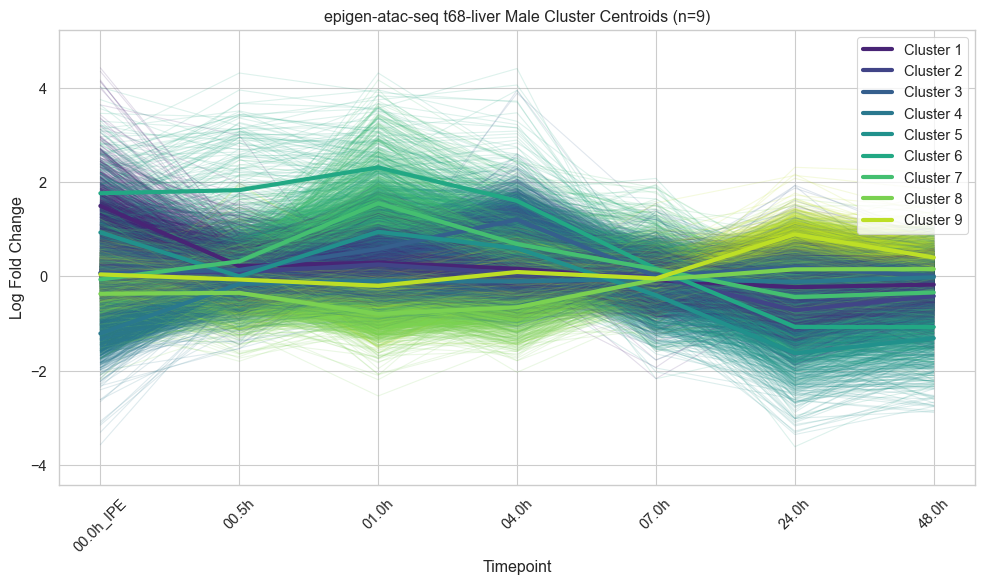

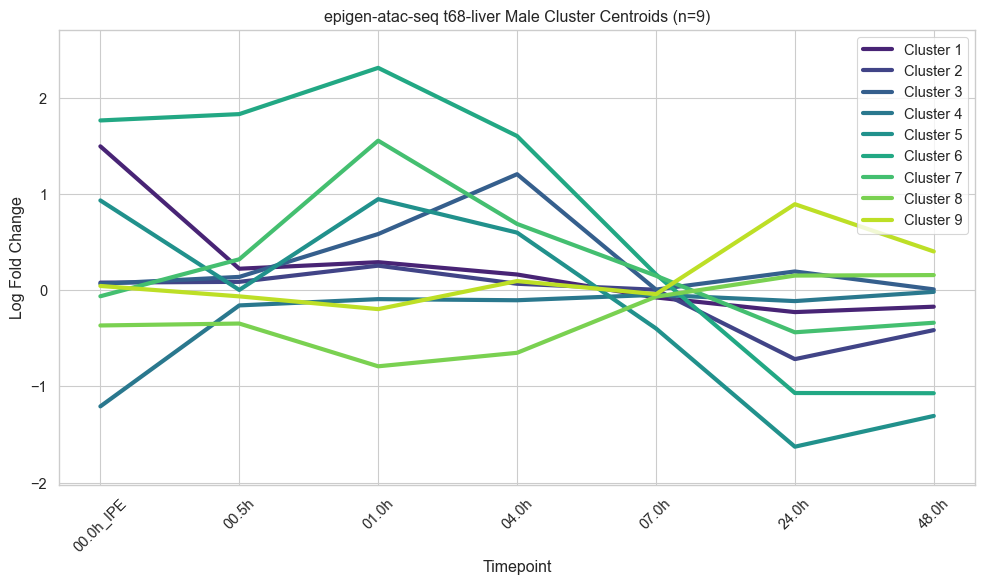

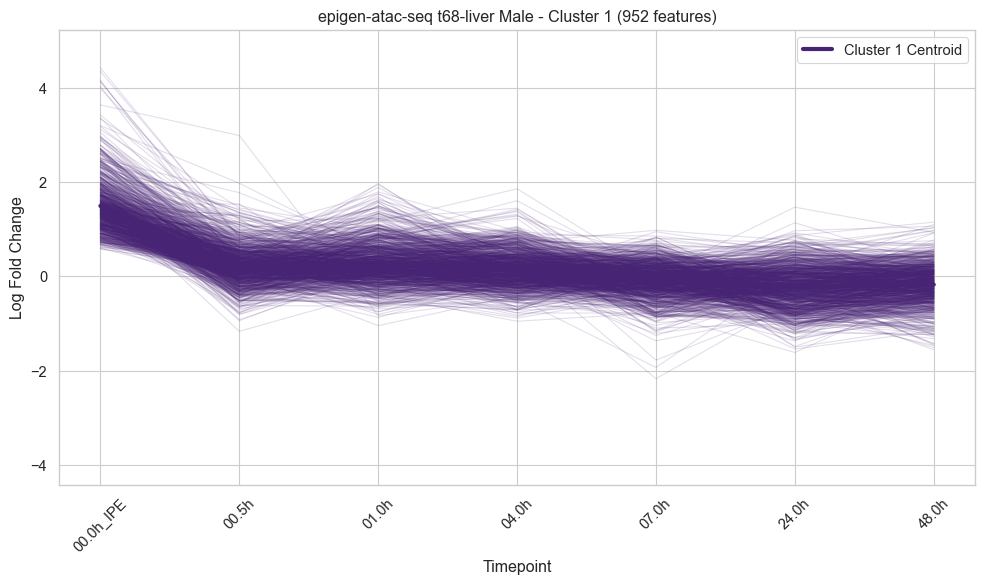

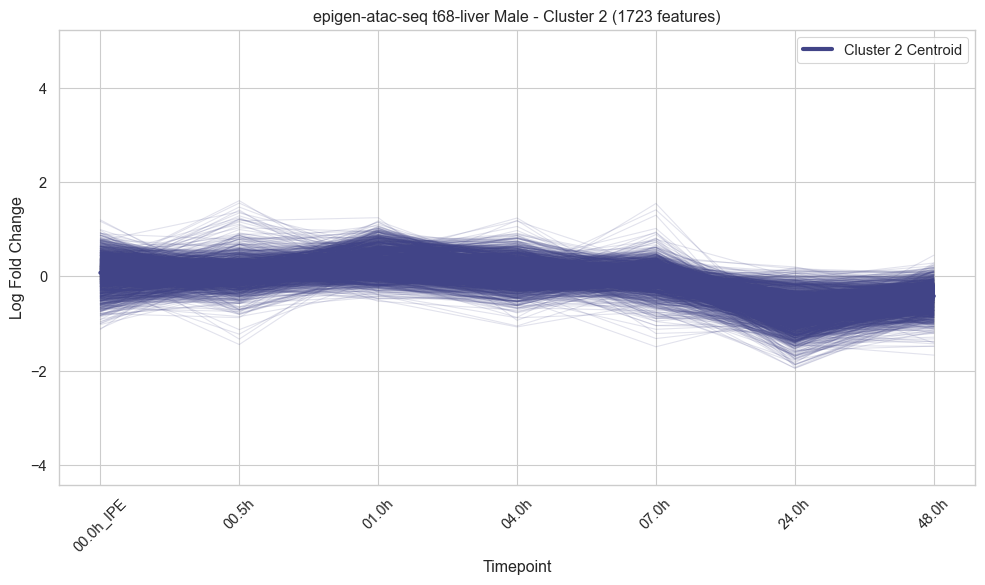

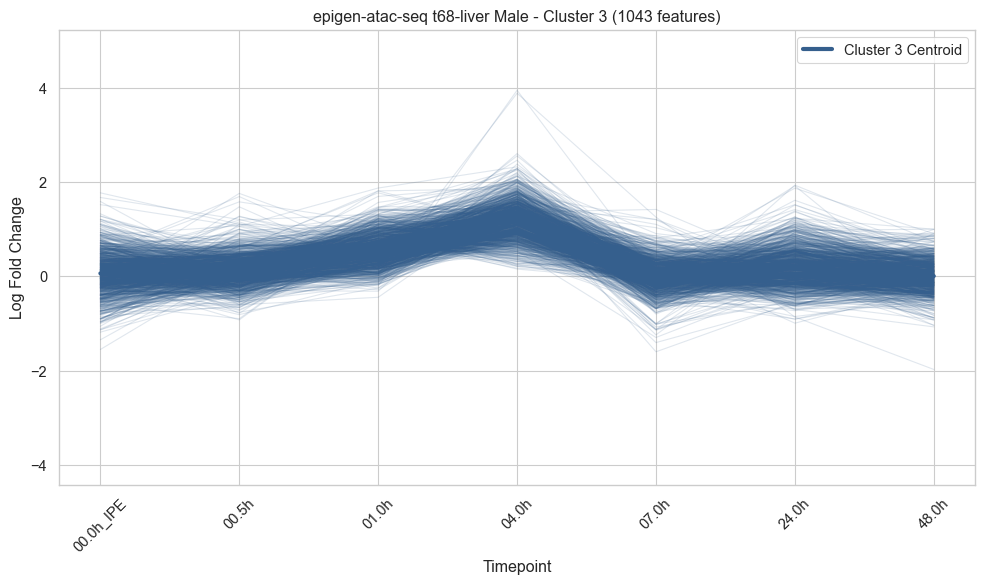

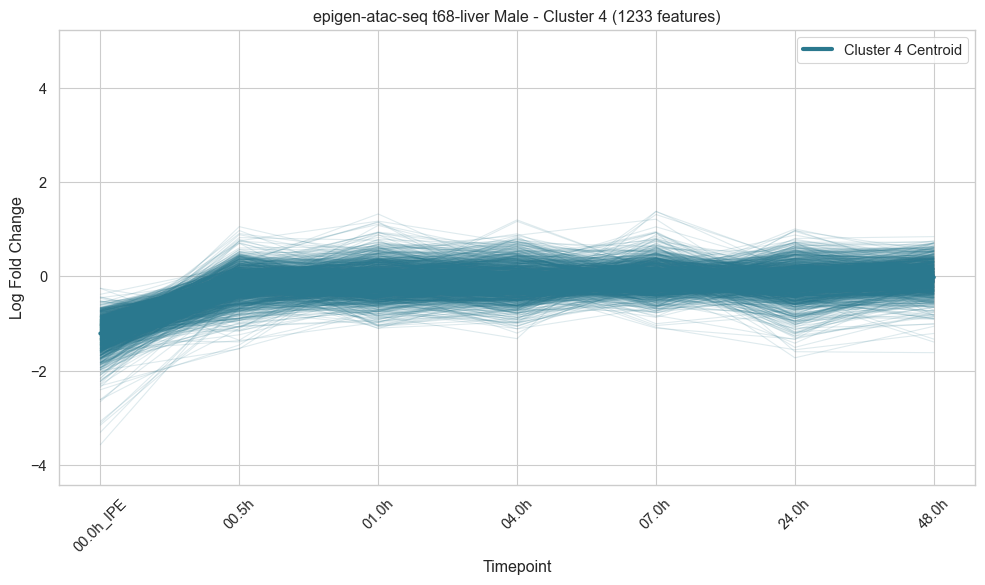

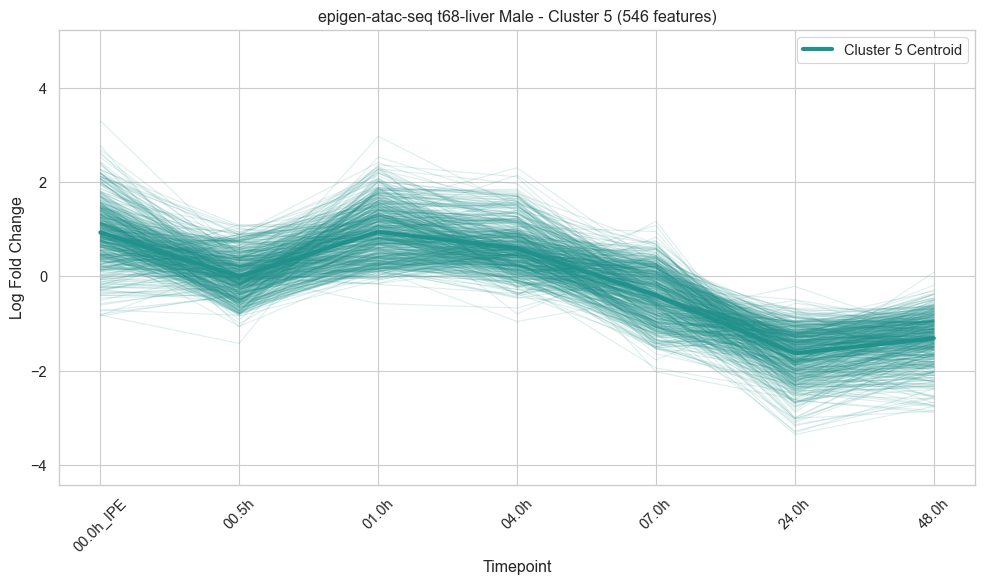

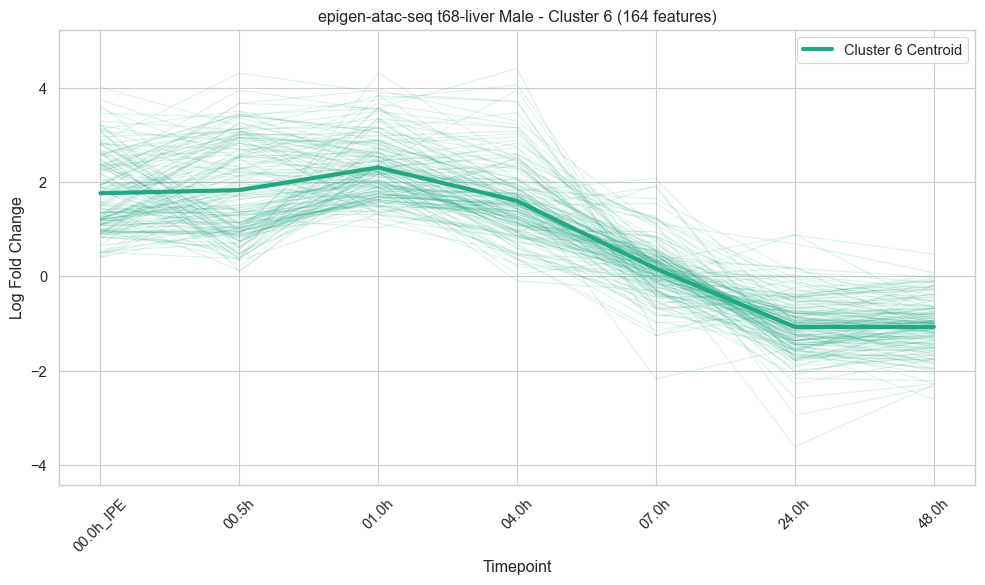

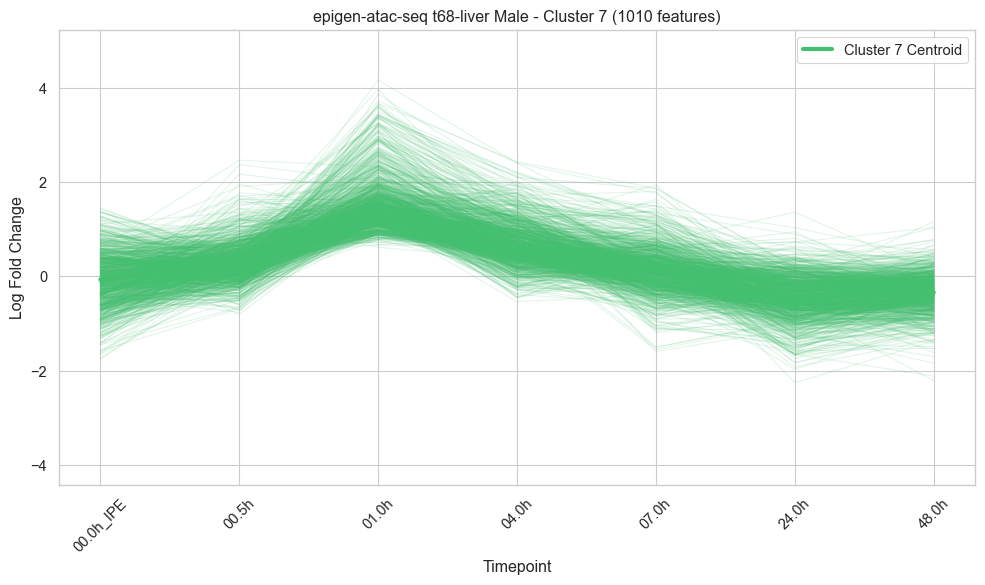

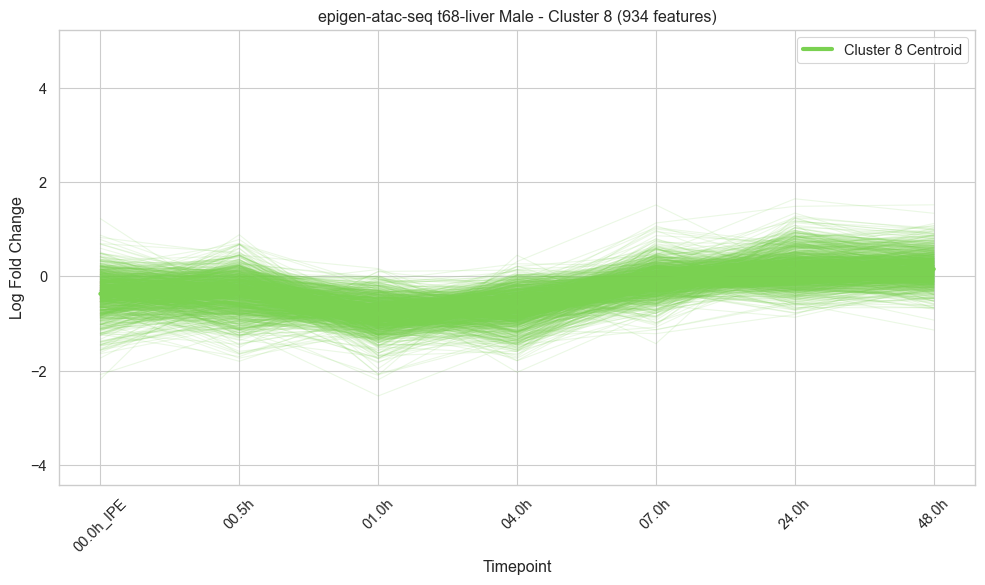

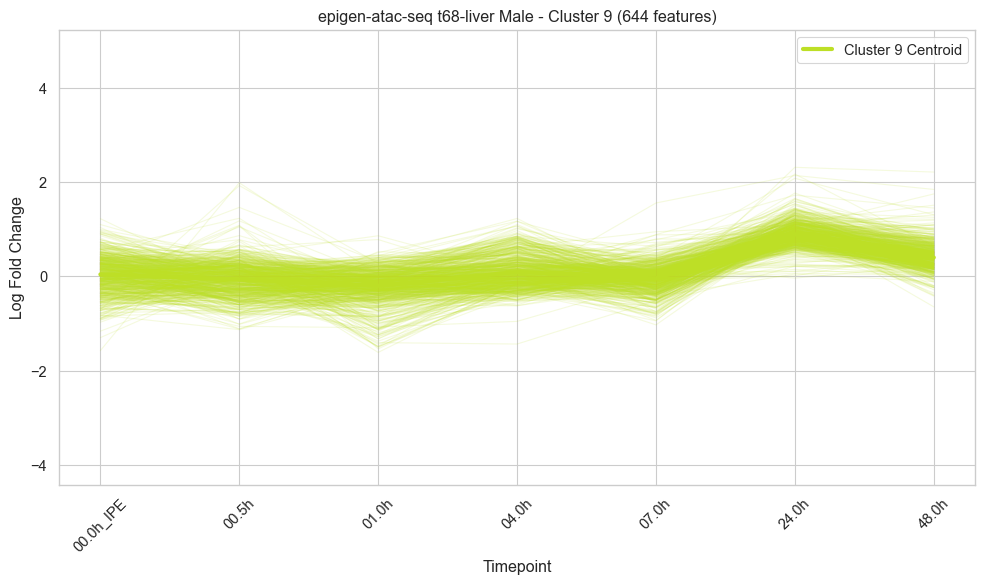

Clustering with 3 clusters...
Using random seed: 9620
Clustering with 4 clusters...
Using random seed: 9620
Clustering with 5 clusters...
Using random seed: 9620
Clustering with 6 clusters...
Using random seed: 9620
Clustering with 7 clusters...
Using random seed: 9620
Clustering with 8 clusters...
Using random seed: 9620
Clustering with 9 clusters...
Using random seed: 9620
Clustering with 10 clusters...
Using random seed: 9620
Clustering with 11 clusters...
Using random seed: 9620
Clustering with 12 clusters...
Using random seed: 9620
Clustering with 13 clusters...
Using random seed: 9620
Clustering with 14 clusters...
Using random seed: 9620
Clustering with 15 clusters...
Using random seed: 9620


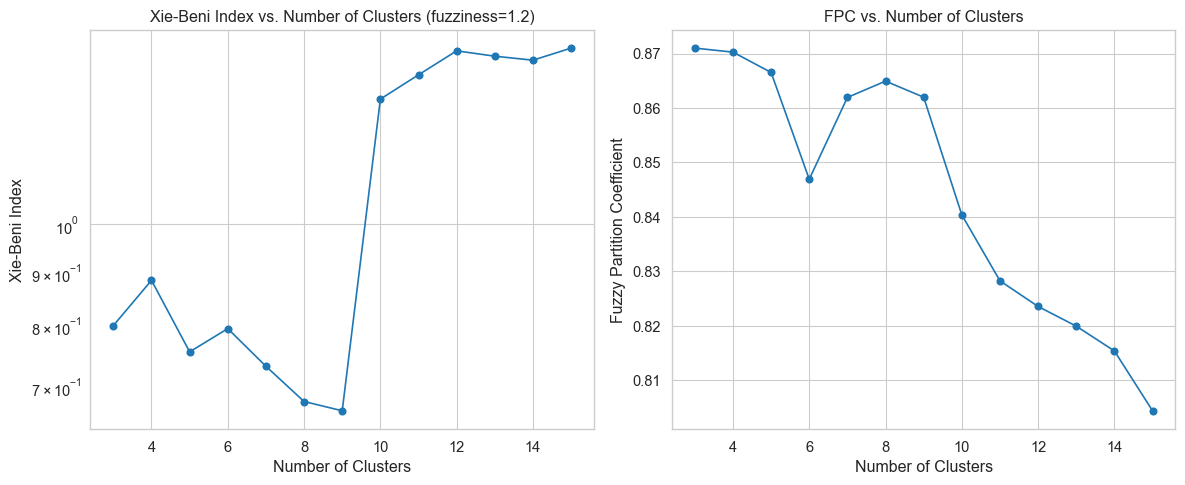

Optimal number of clusters based on Xie-Beni Index: 9


/var/folders/yw/915p5y5n2z78t9tdv03lfh3r0000gq/T/ipykernel_7652/3590732717.py:290: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/Users/curtismcginity/anaconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


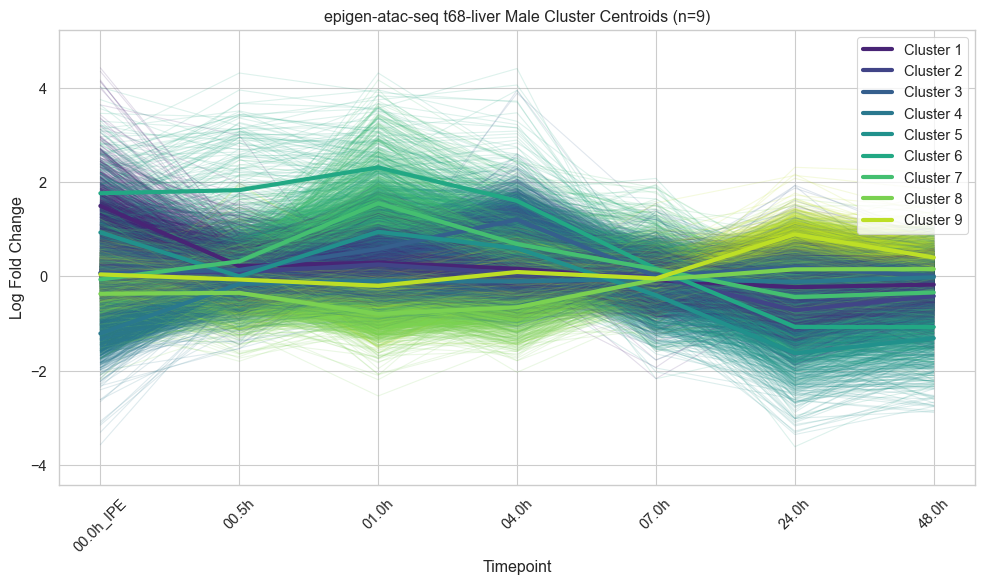

In [10]:
# clustering parameters
seed_male = 9620
fp = 1.2
mi = 1000


# Step 1: Run clustering with 3 clusters
results = cmeans_clustering(dfmale_sig, n_clusters=9, fuzziness=fp, max_iter=mi, random_seed=9620)

# Step 2: Plot all clusters together
plot_cluster_centroids(results, dfmale_sig)

plot_only_centroids(results, dfmale_sig)

# Step 3: Plot each cluster individually
plot_individual_clusters(results, dfmale_sig)
# plot_individual_clusters_sig(results, dfmale_sig)

# Step 4: Find optimal number of clusters
optimal_results = find_optimal_clusters(dfmale_sig, cluster_range=range(3, 16), fuzziness=fp)

# Step 5: Use the optimal number of clusters (based on XBI)
best_n = optimal_results['metrics']['n_clusters'].iloc[
    optimal_results['metrics']['xie_beni_index'].idxmin()
]
print(f"Optimal number of clusters based on Xie-Beni Index: {best_n}")

# Step 6: Get the optimal clustering results
optimal_clustering = optimal_results['all_results'][best_n]

# Step 7: Plot the optimal clustering
plot_cluster_centroids(optimal_clustering, dfmale_sig)

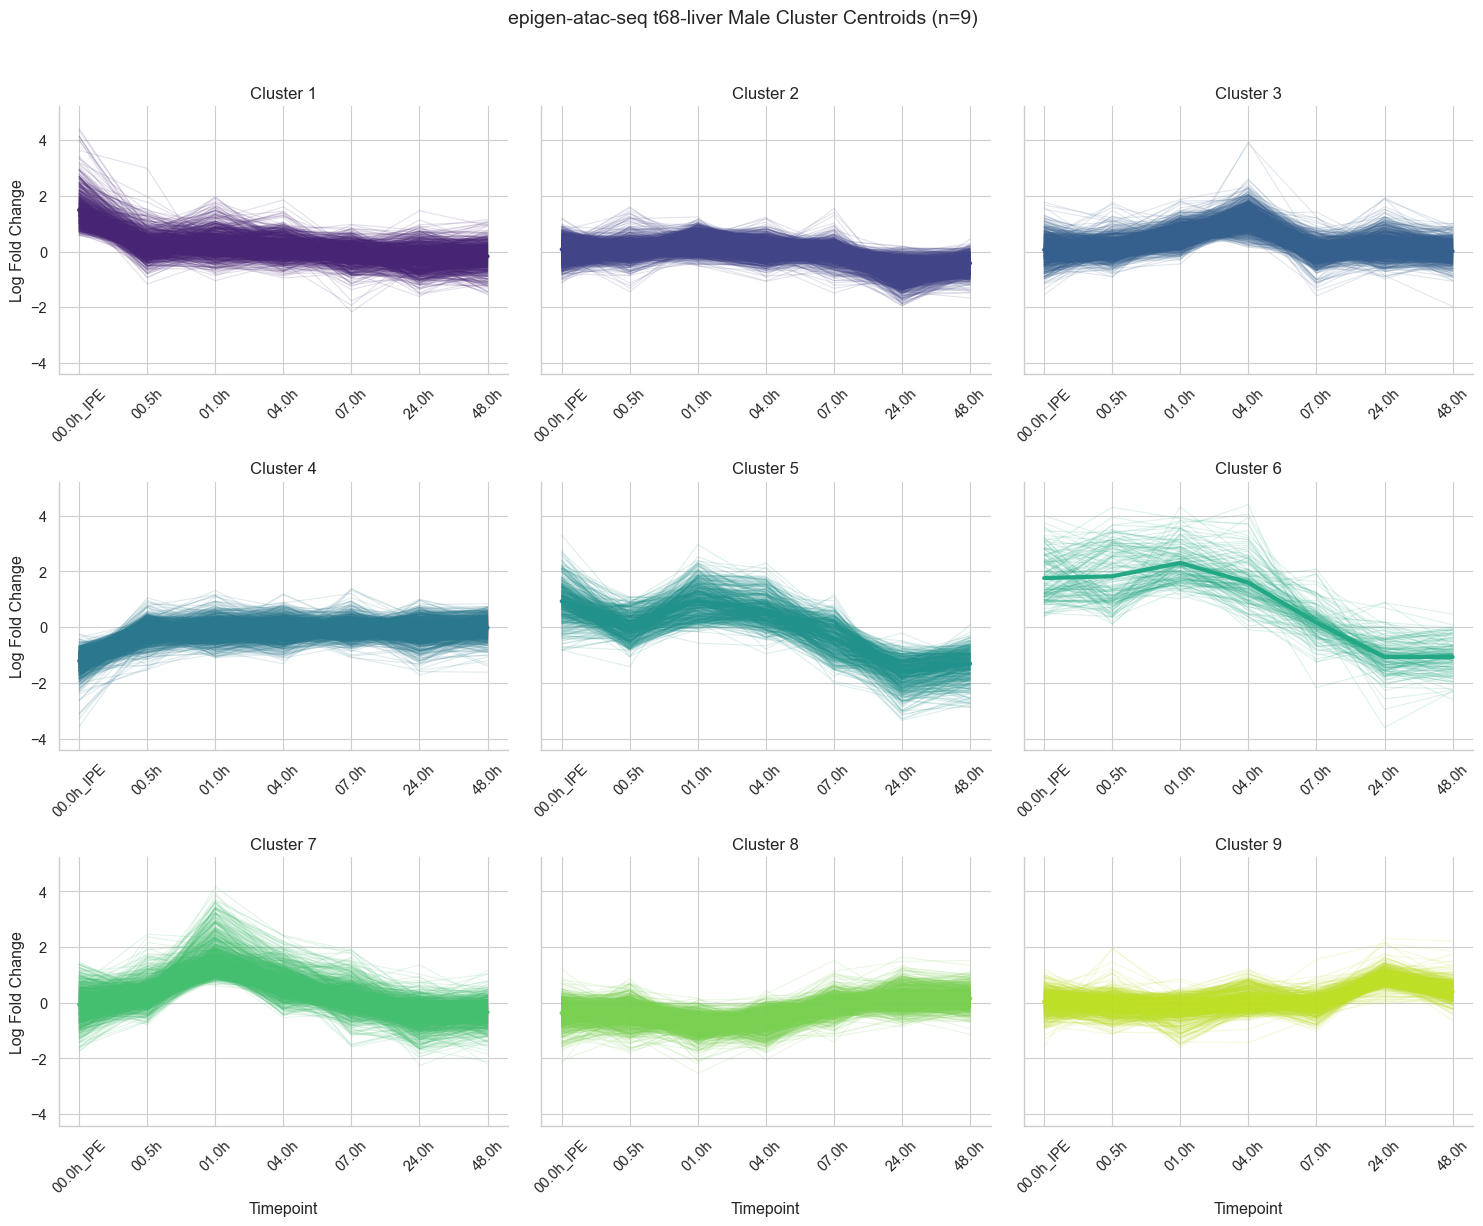

In [ ]:
import math
def plot_cluster_centroids_array(
    clustering_result: Dict[str, Any],
    df: pd.DataFrame,
    show_features: bool = True,
    feature_alpha: float = 0.15,
    palette: str = "viridis",
    n_cols: int = 3
):
    """
    Same inputs and core behaviour as `plot_cluster_centroids`, but displays
    one subplot per cluster arranged in a grid (3 columns, as many rows as
    required).

    Parameters
    ----------
    clustering_result : Dict
        Output from `cmeans_clustering`
    df : pd.DataFrame
        Original dataframe with columns `feature_ID`, `timepoint`, `logFC`, …
    show_features : bool, default=True
        Whether to overlay individual feature trajectories
    feature_alpha : float, default=0.15
        Alpha value for feature trajectories
    palette : str, default="viridis"
        Seaborn colour palette for clusters
    n_cols : int, default=3
        Number of columns in the subplot grid
    """
    # ── Styling ────────────────────────────────────────────────────────────────
    sns.set_style("whitegrid")
    sns.set_context("paper", font_scale=1.2)

    # ── Unpack clustering result ──────────────────────────────────────────────
    centers             = clustering_result["centers"]           # (c x t)
    timepoints          = clustering_result["timepoints"]        # list-like length t
    feature_ids         = clustering_result["feature_ids"]       # list-like length n
    cluster_assignments = clustering_result["cluster_assignments"]  # length n
    n_clusters          = centers.shape[0]

    # ── Colours & titles ──────────────────────────────────────────────────────
    colours      = sns.color_palette(palette, n_clusters)
    assay_name   = df["assay"].iloc[0]  if "assay"  in df.columns else ""
    tissue_name  = df["tissue"].iloc[0] if "tissue" in df.columns else ""

    # ── Shared y-axis limits (match original function) ────────────────────────
    y_min, y_max = df["logFC"].min(), df["logFC"].max()
    y_range      = y_max - y_min
    y_limits     = [y_min - 0.1 * y_range, y_max + 0.1 * y_range]

    # ── Prepare grid ──────────────────────────────────────────────────────────
    n_rows = math.ceil(n_clusters / n_cols)
    fig, axes = plt.subplots(
        n_rows,
        n_cols,
        figsize=(n_cols * 5, n_rows * 4),
        sharey=True,
        squeeze=False
    )
    axes_flat = axes.flatten()

    # Map feature_ID ➔ cluster for quick lookup
    feature_to_cluster = {
        fid: c for fid, c in zip(feature_ids, cluster_assignments)
    }

    # ── Plot each cluster ─────────────────────────────────────────────────────
    for idx in range(n_clusters):
        ax = axes_flat[idx]
        cluster_colour = colours[idx]

        # ── Feature trajectories ────────────────────────────────────────────
        if show_features:
            for feature_id, group in df.groupby("feature_ID"):
                if feature_to_cluster.get(feature_id) == idx:
                    group_sorted = group.sort_values("timepoint")
                    ax.plot(
                        group_sorted["timepoint"],
                        group_sorted["logFC"],
                        color=cluster_colour,
                        alpha=feature_alpha,
                        linewidth=0.8
                    )

        # ── Centroid ────────────────────────────────────────────────────────
        ax.plot(
            timepoints,
            centers[idx],
            color=cluster_colour,
            linewidth=3,
            label=f"Cluster {idx + 1}"
        )

        # ── Axis cosmetics ─────────────────────────────────────────────────
        ax.set_title(f'Cluster {cluster_idx+1} ({n_features} features)', fontsize=12)
        ax.set_ylim(y_limits)
        ax.set_xticks(range(len(timepoints)))
        ax.set_xticklabels(timepoints, rotation=45)

        # Show x-label only on bottom row, y-label only on first column
        if idx // n_cols == n_rows - 1:
            ax.set_xlabel("Timepoint")
        if idx % n_cols == 0:
            ax.set_ylabel("Log Fold Change")

        # Remove top and right spines
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

    # ── Hide any unused axes ─────────────────────────────────────────────────
    for j in range(n_clusters, n_rows * n_cols):
        axes_flat[j].axis("off")

    fig.suptitle(
        f"{assay_name} {tissue_name} Male Cluster Centroids (n={n_clusters})",
        fontsize=14,
        y=1.02
    )
    plt.tight_layout()
    plt.show()

plot_cluster_centroids_array(optimal_clustering, dfmale_sig)

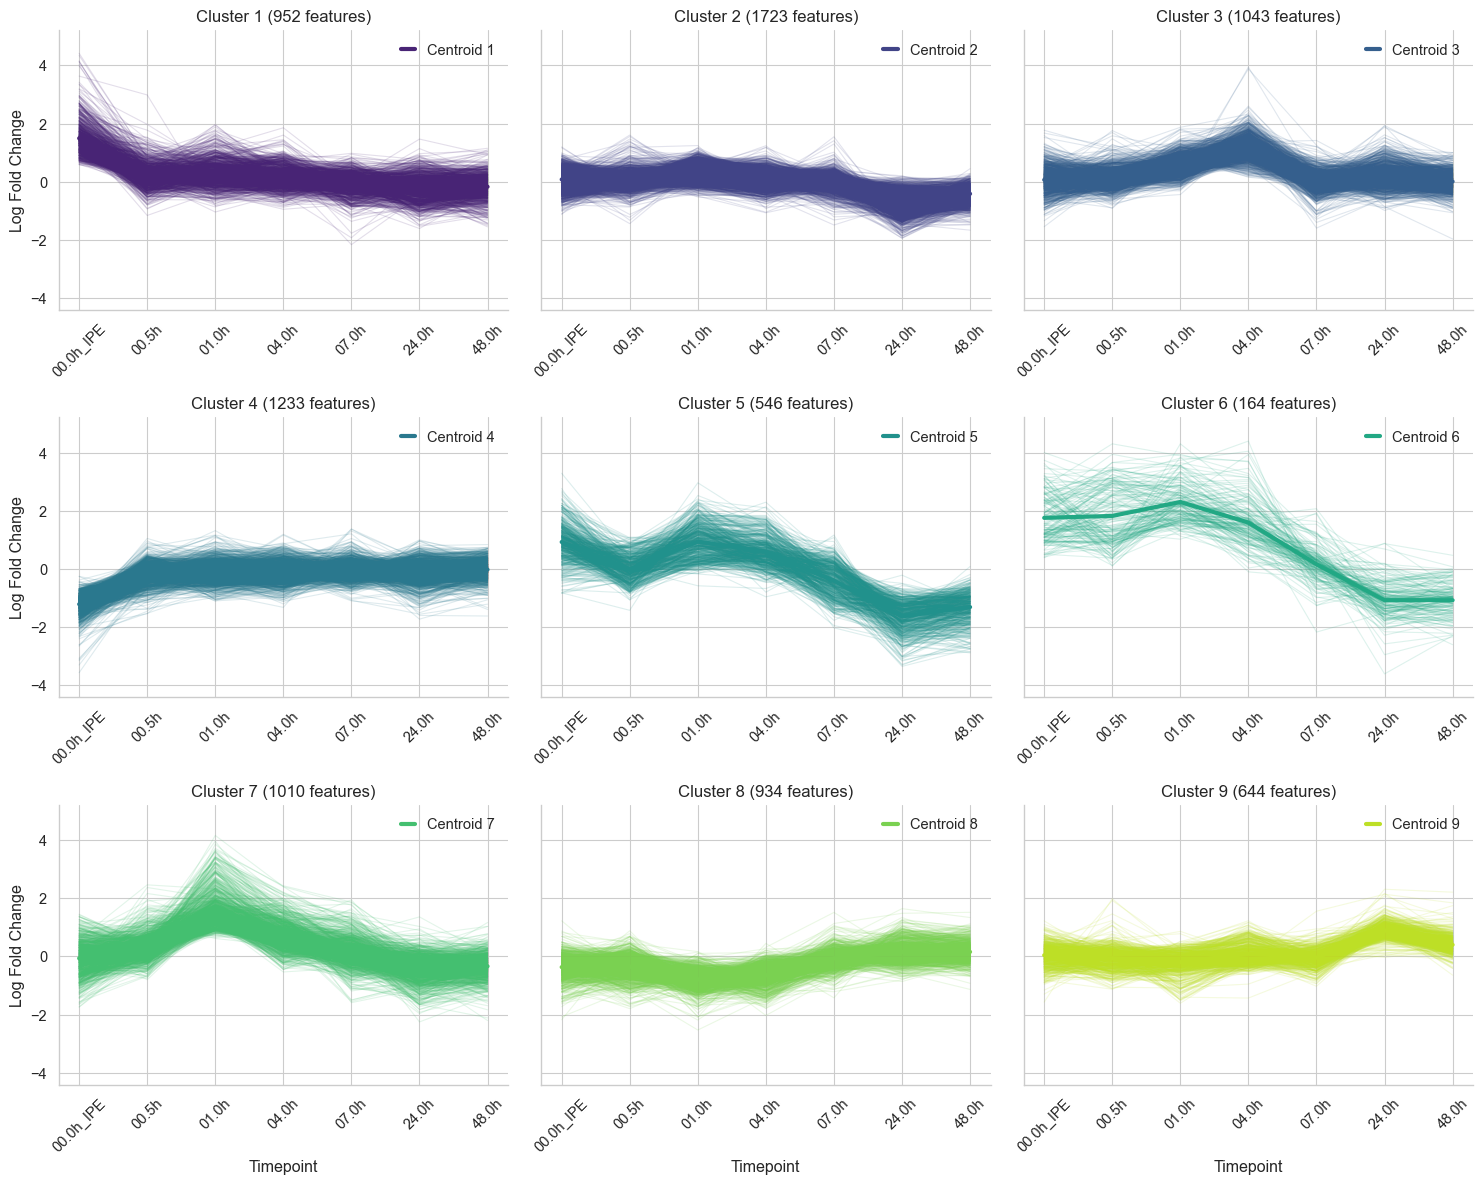

In [9]:
def plot_cluster_centroids_array(
    clustering_result: Dict[str, Any],
    df: pd.DataFrame,
    show_features: bool = True,
    feature_alpha: float = 0.15,
    palette: str = "viridis",
    n_cols: int = 3
):
    """
    Display one subplot per cluster (3 columns × as many rows as needed),
    mirroring the styling of `plot_individual_clusters`.

    Parameters
    ----------
    clustering_result : Dict
        Output from `cmeans_clustering`
    df : pd.DataFrame
        Original dataframe with columns `feature_ID`, `timepoint`, `logFC`, …
    show_features : bool, default=True
        Whether to overlay individual feature trajectories
    feature_alpha : float, default=0.15
        Alpha transparency for feature trajectories
    palette : str, default="viridis"
        Seaborn colour palette for clusters
    n_cols : int, default=3
        Number of columns in the subplot grid
    """
    # ── Styling ───────────────────────────────────────────────────────────────
    sns.set_style("whitegrid")
    sns.set_context("paper", font_scale=1.2)

    # ── Unpack clustering result ──────────────────────────────────────────────
    centers             = clustering_result["centers"]            # (c x t)
    timepoints          = clustering_result["timepoints"]         # list-like length t
    feature_ids         = clustering_result["feature_ids"]        # length n
    cluster_assignments = clustering_result["cluster_assignments"]# length n
    n_clusters          = centers.shape[0]

    # ── Colour palette & shared y-axis limits ─────────────────────────────────
    colours   = sns.color_palette(palette, n_clusters)
    y_min, y_max = df["logFC"].min(), df["logFC"].max()
    y_range      = y_max - y_min
    y_limits     = [y_min - 0.1 * y_range, y_max + 0.1 * y_range]

    # ── Prepare grid ──────────────────────────────────────────────────────────
    n_rows = math.ceil(n_clusters / n_cols)
    fig, axes = plt.subplots(
        n_rows,
        n_cols,
        figsize=(n_cols * 5, n_rows * 4),
        sharey=True,
        squeeze=False
    )
    axes_flat = axes.flatten()

    # Map feature_ID ➔ cluster for quick lookup
    feature_to_cluster = dict(zip(feature_ids, cluster_assignments))

    # ── Plot each cluster ─────────────────────────────────────────────────────
    for idx in range(n_clusters):
        ax = axes_flat[idx]
        cluster_colour = colours[idx]

        # Feature trajectories
        if show_features:
            for feature_id, group in df.groupby("feature_ID"):
                if feature_to_cluster.get(feature_id) == idx:
                    group_sorted = group.sort_values("timepoint")
                    ax.plot(
                        group_sorted["timepoint"],
                        group_sorted["logFC"],
                        color=cluster_colour,
                        alpha=feature_alpha,
                        linewidth=0.8
                    )

        # Centroid
        ax.plot(
            timepoints,
            centers[idx],
            color=cluster_colour,
            linewidth=3,
            label=f"Centroid {idx + 1}"
        )

        # Cluster size for title
        n_features = int(np.sum(cluster_assignments == idx))
        ax.set_title(f"Cluster {idx + 1} ({n_features} features)", fontsize=12)

        # Cosmetics
        ax.set_ylim(y_limits)
        ax.set_xticks(range(len(timepoints)))
        ax.set_xticklabels(timepoints, rotation=45)

        # Labels only on bottom row / first column
        if idx // n_cols == n_rows - 1:
            ax.set_xlabel("Timepoint")
        if idx % n_cols == 0:
            ax.set_ylabel("Log Fold Change")

        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.legend(frameon=False, handlelength=1)

    # Hide unused axes
    for j in range(n_clusters, n_rows * n_cols):
        axes_flat[j].axis("off")

    plt.tight_layout()
    plt.show()


plot_cluster_centroids_array(optimal_clustering, dfmale_sig)